# LAT Thermal Control Plots

### Robert Cameron, September 2015

In [1]:
from astropy.table import Table, Column
import numpy as np
from os.path import expanduser
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (MONTHLY, YEARLY, DateFormatter, rrulewrapper, RRuleLocator, drange)
import pandas as pd
import datetime as dt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [2]:
# Give range for plots
dntmin="2008-01-01 00:00:00"
dntmax="2020-01-01 00:00:00"

Year_Qtr = "2019_Q4" # used to name output figures

HOME = expanduser("/Users/jeggen/ISOC/2019_Q4/")
navfile = HOME+"/nav.history"
htrfile = HOME+"/htr.history"

outFig = HOME+"therm_control_"+Year_Qtr

In [3]:
# read regular ASCII tabular file of Fermi navigation history
navtab = Table.read(navfile, format='ascii',names=('ymd','hms','s1970','x','y','z','vx','vy','vz'))
ymd = navtab['ymd']
hms = navtab['hms']
s1970 = navtab['s1970']
x = navtab['x']
y = navtab['y']
z = navtab['z']
vx = navtab['vx']
vy = navtab['vy']
vz = navtab['vz']
d1970 = s1970/86400.0
JD = d1970 + 2440587.5
DJ2000 = JD - 2451545.0
yr = DJ2000/365.25 + 2000.0

In [4]:
# caculate beta angle from Fermi navigation history
# use Sun position calculations from http://aa.usno.navy.mil/faq/docs/SunApprox.php

g = np.radians(357.529 + 0.98560028 * DJ2000)    # g = mean anomaly of the Sun
q = 280.459 + 0.98564736 * DJ2000  # q = mean longitude of the Sun, in degrees
L = np.radians(q + 1.915 * np.sin(g) + 0.020 * np.sin(2*g)) # L = geocentric apparent ecliptic longitude of the Sun, adjusted for aberration
rAU = 1.00014 - 0.01671 * np.cos(g) - 0.00014 * np.cos(2*g)  # rAU = Sun-Earth distance in AU
e = np.radians(23.439 - 0.00000036 * DJ2000)  # e = mean obliquity of the ecliptic

# get Sun's RA and Dec
tanRA = np.cos(e) * np.tan(L)
Zsun = np.sin(e) * np.sin(L)
sun_Dec = np.arcsin(Zsun)
sun_RA = np.arctan(np.cos(e) * np.sin(L),np.cos(L))
Xsun = np.cos(sun_Dec) * np.cos(sun_RA)
Ysun = np.cos(sun_Dec) * np.sin(sun_RA)

# normalize the Fermi position and velocity vectors
pos = np.sqrt(x*x + y*y + z*z)
vel = np.sqrt(vx*vx + vy*vy + vz*vz)
xn = x/pos
yn = y/pos
zn = z/pos
vxn = vx/vel
vyn = vy/vel
vzn = vz/vel

# get the vector to the Fermi orbit pole from the cross product of the Fermi position and velocity vectors
Polex = yn*vzn - zn*vyn
Poley = zn*vxn - xn*vzn
Polez = xn*vyn - yn*vxn

# calculate angle between Sun Vector and Fermi orbit pole, using dot product
# NOTE: beta angle is the complement of the angle from the dot product, so use sin instead of cos
sinbeta = Xsun*Polex + Ysun*Poley + Zsun*Polez
beta = np.degrees(np.arcsin(sinbeta))

In [5]:
doyformat = "%j"
doy = [dt.datetime.strptime(ymd[i],"%Y-%m-%d").timetuple().tm_yday for i in range(len(ymd))]
dnt = [dt.datetime.strptime(ymd[i]+hms[i],"%Y-%m-%d%H:%M:%S") for i in range(len(ymd))]

In [6]:
# read irregular ASCII tabular file of history of VCHP control

df = pd.read_csv(htrfile, parse_dates=[1], delimiter="\t",header=None)
(hymd,tot0,off0,tot6,off6,tot7,off7) = (df[0],df[2],df[3],df[5],df[6],df[8],df[9])

ok = (tot0 > 0) & (tot6 > 0) & (tot7 > 0)

hymd = hymd[ok]
tot0 = tot0[ok]
off0 = off0[ok]
tot6 = tot6[ok]
off6 = off6[ok]
tot7 = tot7[ok]
off7 = off7[ok]
f0 = off0/tot0
f6 = off6/tot6
f7 = off7/tot7

VCHP0 = 1-pd.Series.rolling(f0,axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP6 = 1-pd.Series.rolling(f6,axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP7 = 1-pd.Series.rolling(f7,axis=0,window=20,win_type='boxcar',center=True).mean()

fx = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in hymd]

<IPython.core.display.Javascript object>


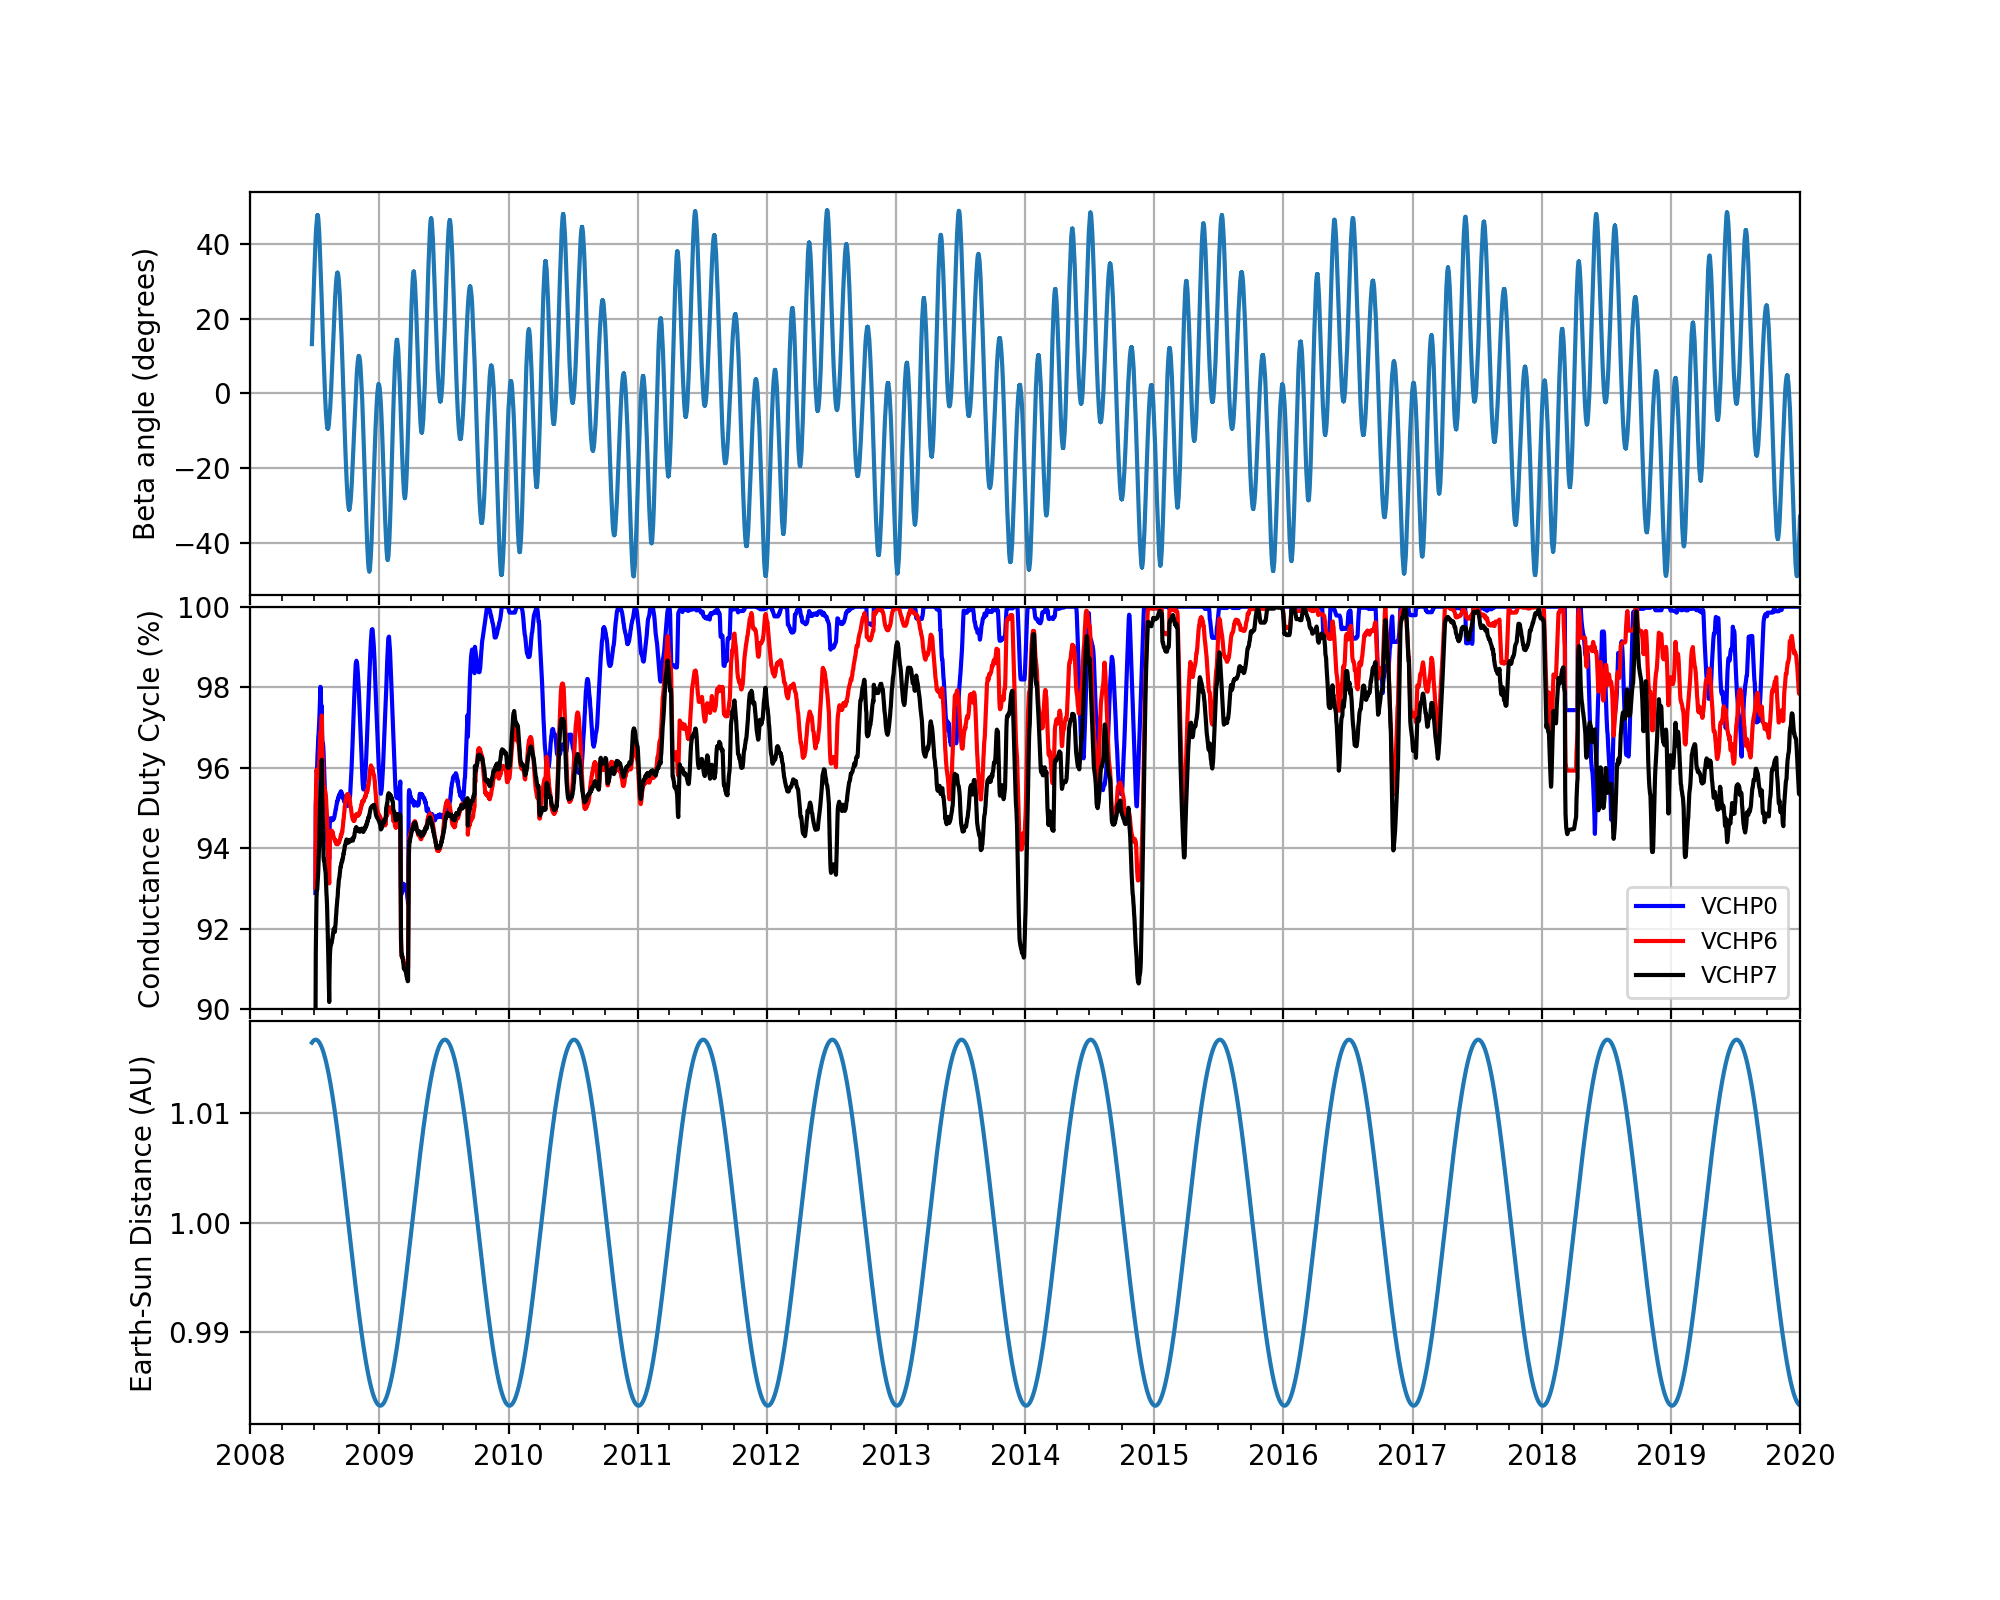

/Users/jeggen/miniconda2/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [7]:
# 3 subplots for beta, VCHP, rAU, where the axes array is 1-d

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize = [10, 8])

#years    = mdates.YearLocator()   # every year
#months   = mdates.MonthLocator()  # every month
#yearsFmt = mdates.DateFormatter('%Y')

#dntmin="2008-01-01 00:00:00"
#dntmax="2020-01-01 00:00:00"
dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")

yrule = rrulewrapper(YEARLY, interval=1)
yloc = RRuleLocator(yrule)
mrule = rrulewrapper(MONTHLY, interval=3)
mloc = RRuleLocator(mrule)

ax1.xaxis.set_major_locator(yloc)
ax3.xaxis.set_minor_locator(mloc)
ax1.plot(dnt, beta)
ax1.set_xlim(dnt0, dnt1)

ax1.grid(True)
ax1.set_ylabel('Beta angle (degrees)')

ax2.plot(fx,VCHP0*100,'-b',label='VCHP0')
ax2.plot(fx,VCHP6*100,'-r',label='VCHP6')
ax2.plot(fx,VCHP7*100,'-k',label='VCHP7')
ax2.grid(True)
ax2.set_ylim(90,100)
ax2.xaxis.set_major_locator(yloc)
ax3.xaxis.set_minor_locator(mloc)
ax2.legend(loc='lower right',fontsize='small')
ax2.set_ylabel('Conductance Duty Cycle (%)')

ax3.plot(dnt,rAU)
ax3.grid(True)
ax3.set_ylabel('Earth-Sun Distance (AU)')
ax3.xaxis.set_major_locator(yloc)
ax3.xaxis.set_minor_locator(mloc)

fig.subplots_adjust(hspace=0.03)
plt.savefig(outFig)

<IPython.core.display.Javascript object>


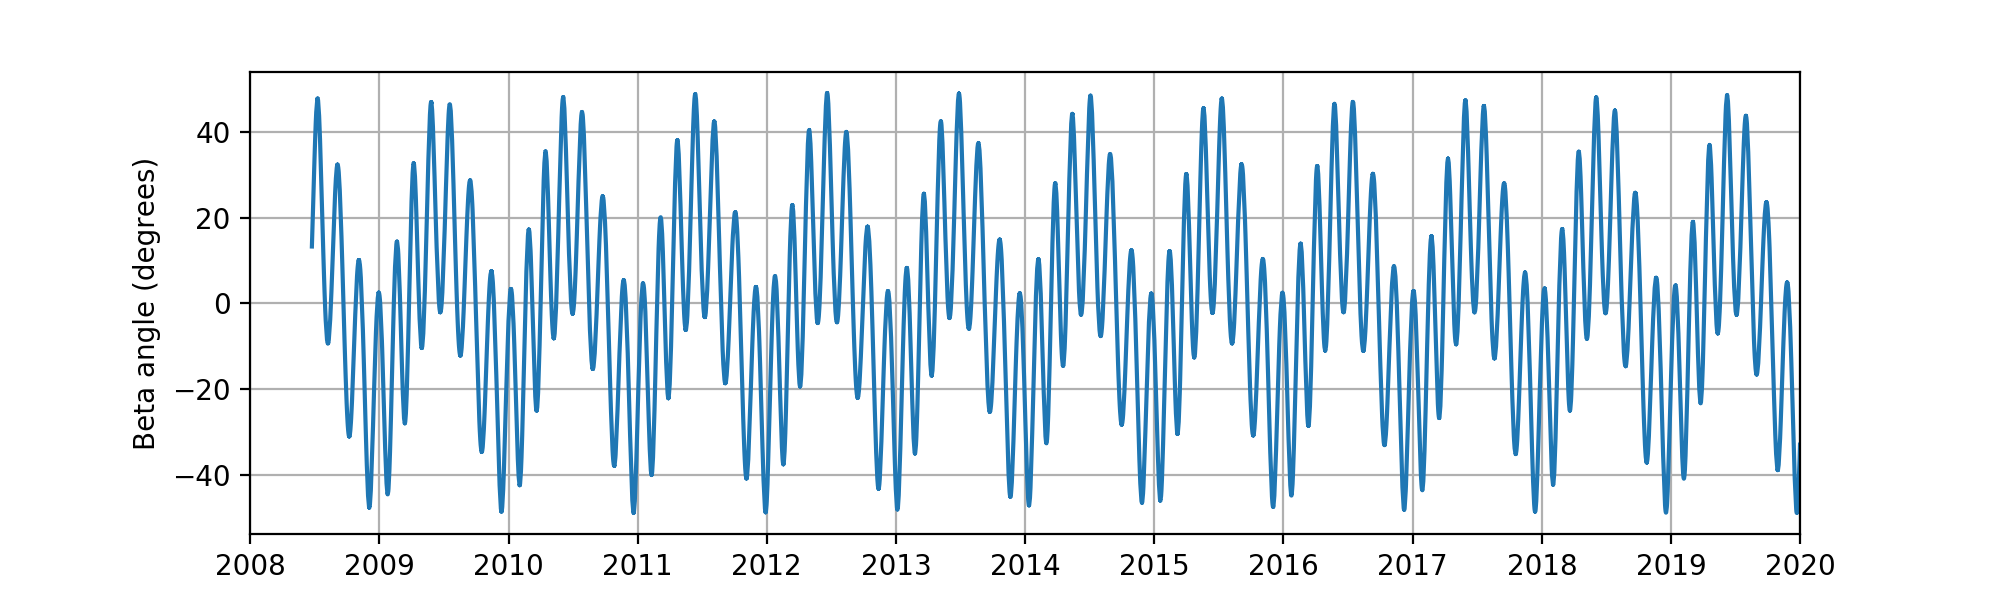

Text(0,0.5,'Beta angle (degrees)')

In [8]:

# set plot date range
#dntmin="2008-01-01 00:00:00"
#dntmax="2020-01-01 00:00:00"
dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")

plt.rc('font', size = 10)
fig, ax = plt.subplots(figsize = [10, 3])
plt.plot_date(dnt, beta,'-')
rule = rrulewrapper(YEARLY, interval=1)
loc = RRuleLocator(rule)
plt.xlim(dnt0,dnt1)
ax.xaxis.set_major_locator(loc)
plt.grid(True)
plt.ylabel('Beta angle (degrees)')
#ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_tick_params(rotation=30, labelsize=10)

<IPython.core.display.Javascript object>


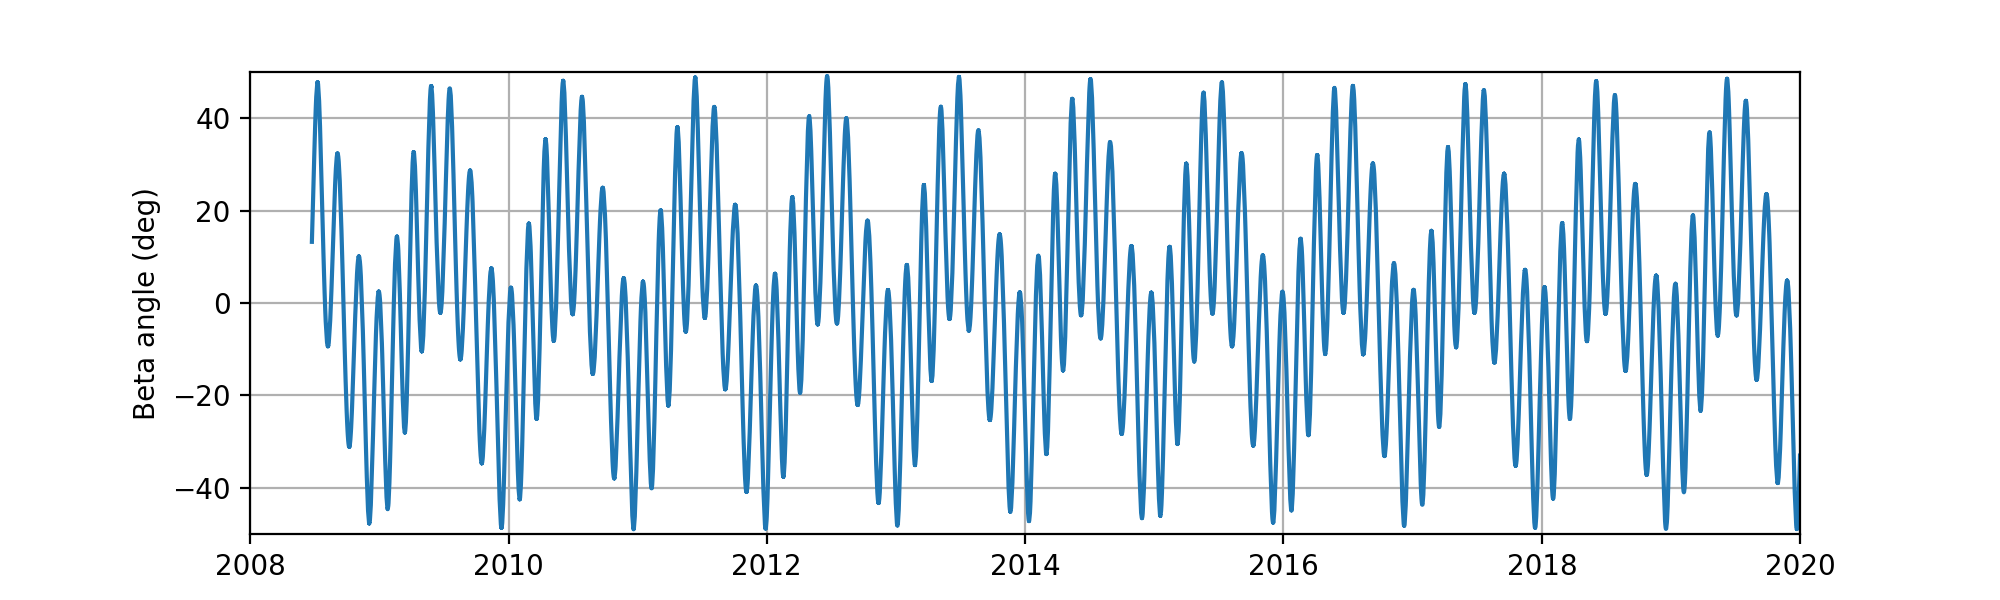

Text(0,0.5,'Beta angle (deg)')

In [9]:
#majorLocator = MultipleLocator(1)
#majorFormatter = FormatStrFormatter('%d')
#minorLocator = AutoMinorLocator(12)

def color_legend_texts(leg):
    """Color legend texts based on color of corresponding lines"""
    for line, txt in zip(leg.get_lines(), leg.get_texts()):
        txt.set_color(line.get_color())  

# set plot date range
#dntmin="2008-01-01 00:00:00"
#dntmax="2020-01-01 00:00:00"
dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")

plt.figure(figsize = [10, 3])
plt.rc('font', size = 10)
plt.xlim(dnt0,dnt1)
plt.plot(dnt,beta)
plt.ylim([-50.0,50.0])
#plt.xaxis.set_major_locator(majorLocator)
#plt.xaxis.set_minor_locator(minorLocator)
plt.grid(True)
plt.ylabel('Beta angle (deg)')

<IPython.core.display.Javascript object>


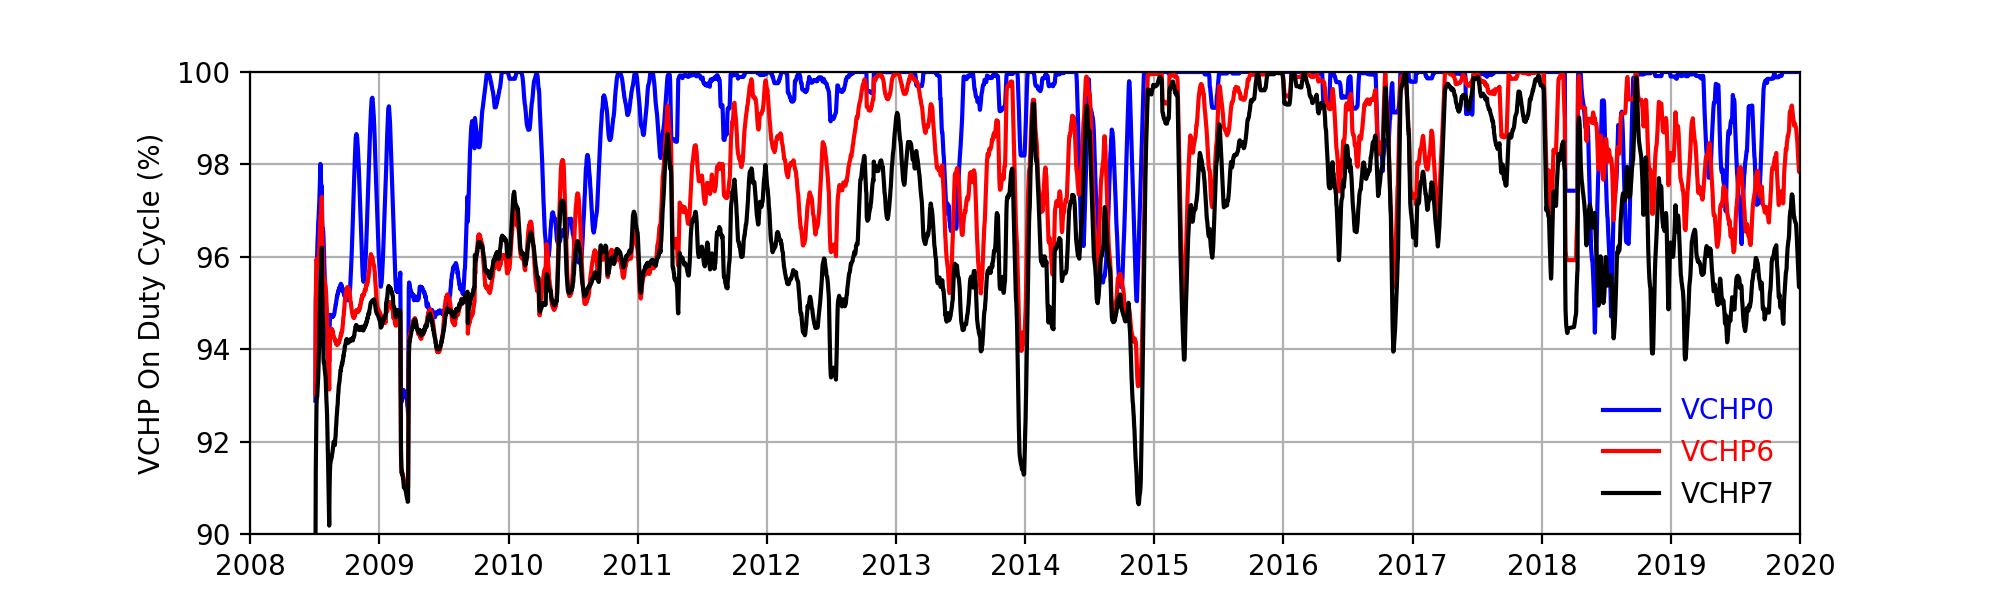

In [10]:
def color_legend_texts(leg):
    """Color legend texts based on color of corresponding lines"""
    for line, txt in zip(leg.get_lines(), leg.get_texts()):
        txt.set_color(line.get_color())  

# set plot date range
#dntmin="2008-01-01 00:00:00"
#dntmax="2020-01-01 00:00:00"
dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")

plt.rc('font', size = 10)
fig, ax = plt.subplots(figsize = [10, 3])
rule = rrulewrapper(YEARLY, interval=1)
loc = RRuleLocator(rule)
plt.xlim(dnt0,dnt1)
ax.xaxis.set_major_locator(loc)

plt.plot(fx,VCHP0*100,'-b',label='VCHP0')
plt.plot(fx,VCHP6*100,'-r',label='VCHP6')
plt.plot(fx,VCHP7*100,'-k',label='VCHP7')
plt.grid(True)
plt.ylim(90,100)
plt.ylabel('VCHP Conductance Duty Cycle')
plt.ylabel('VCHP On Duty Cycle (%)')
legend = ax.legend(loc='lower right', fontsize='medium', markerscale = 0,frameon = 0)
color_legend_texts(legend)

<IPython.core.display.Javascript object>


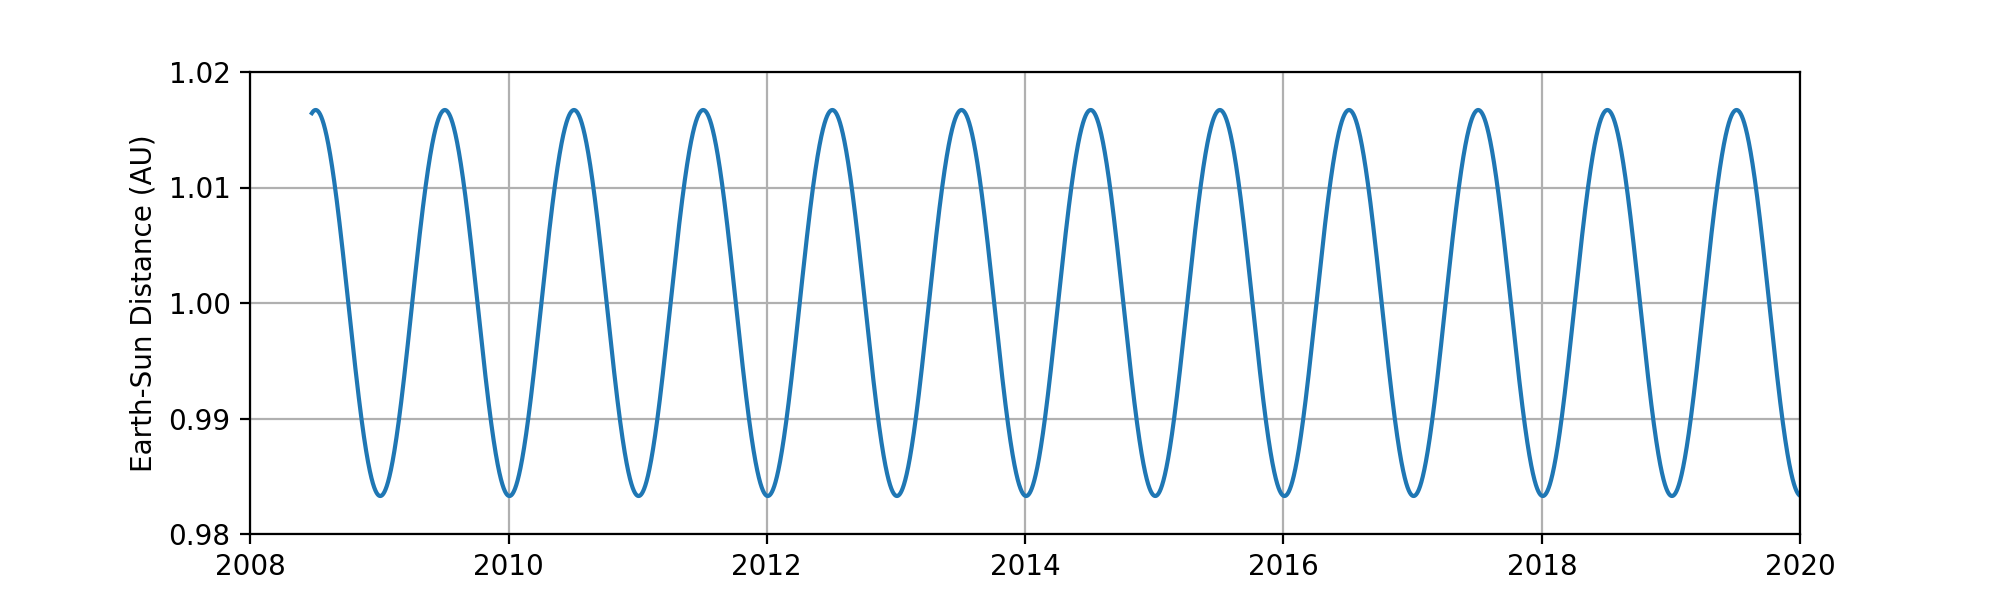

Text(0,0.5,'Earth-Sun Distance (AU)')

In [11]:
plt.figure(figsize = [10, 3])
plt.rc('font', size = 10)

# set plot date range
#dntmin="2008-01-01 00:00:00"
#dntmax="2020-01-01 00:00:00"
dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")
plt.xlim(dnt0,dnt1)

plt.plot(dnt, rAU)
plt.grid(True)
#plt.xaxis.set_minor_locator(months)
plt.ylim(0.98, 1.02)
plt.ylabel('Earth-Sun Distance (AU)')